# Tiền xử lý dữ liệu:

In [29]:
import pandas as pd
import numpy as np
import re
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt

In [81]:
class DataPreprocessor:
    def __init__(self, df=None):
        """
        Khởi tạo đối tượng DataPreprocessor với dataframe
        df lưu trữ dữ liệu cần xử lý
        scaler lưu trữ đối tượng scaler đã fit (nếu có)
        encoders lưu trữ các bộ mã hóa phân loại đã fit (nếu có)
        """
        self.df = df
        self.numeric_cols = []
        self.categorical_cols = []
        self.scaler = None
        self.encoders = {}
    def set_numeric_cols(self, cols):
        """Đặt cột số cho DataPreprocessor"""
        for col in cols:
            if col not in self.df.columns:
                raise ValueError(f"Cột {col} không tồn tại trong DataFrame")
        self.numeric_cols = list(cols)
    def set_categorical_cols(self, cols):
        """Đặt cột phân loại cho DataPreprocessor"""
        for col in cols:
            if col not in self.df.columns:
                raise ValueError(f"Cột {col} không tồn tại trong DataFrame")
        self.categorical_cols = list(cols)
    def __repr__(self):
        """Hiển thị thông tin về đối tượng DataPreprocessor"""
        return str(self.df.info())

    # Đọc file
    @staticmethod
    def read_file(path):
        """Đọc file dữ liệu từ đường dẫn và trả về đối tượng DataPreprocessor (chỉ có thể đọc file .csv, .xlsx, .json)"""
        try:
            if path.endswith(".csv"):
                df = pd.read_csv(path)
            elif path.endswith(".xlsx") or path.endswith(".xls"):
                df = pd.read_excel(path)
            elif path.endswith(".json"):
                df = pd.read_json(path)
            else:
                raise ValueError("Định dạng không hỗ trợ. Chỉ hỗ trợ CSV, XLSX, JSON.")
            return DataPreprocessor(df)
        except Exception as e:
            print("Lỗi đọc file:", e)
            return None

    # Xử lý giá trị thiếu
    def fill_missing(self, numeric_method="median", categorical_method="mode"):
        """
        Điền giá trị thiếu cho dataframe.
        - numeric_method: 'mean', 'median', 'mode', 'ffill', 'bfill'
        - categorical_method: 'mode', 'ffill', 'bfill'
        mean: trung bình
        median: trung vị
        mode: giá trị xuất hiện nhiều nhất
        ffill: điền giá trị trước đó
        bfill: điền giá trị sau đó
        Nếu phương pháp không hợp lệ, sẽ xuất ra lỗi ValueError.
        Mặc định là median cho cột số và mode cho cột phân loại.
        """

        # Xử lý giá trị thiếu cho cột số 
        for col in self.numeric_cols:
            if numeric_method == "mean":
                self.df[col] = self.df[col].fillna(self.df[col].mean())
            elif numeric_method == "median":
                self.df[col] = self.df[col].fillna(self.df[col].median())
            elif numeric_method == "mode":
                self.df[col] = self.df[col].fillna(self.df[col].mode()[0])
            elif numeric_method == "ffill":
                self.df[col] = self.df[col].fillna(method="ffill")
            elif numeric_method == "bfill":
                self.df[col] = self.df[col].fillna(method="bfill")
            else:
                raise ValueError("numeric_method không hợp lệ")

        # Xử lý giá trị thiếu cho cột phân loại 
        for col in self.categorical_cols:
            if categorical_method == "mode":
                self.df[col] = self.df[col].fillna(self.df[col].mode()[0])
            elif categorical_method == "ffill":
                self.df[col] = self.df[col].fillna(method="ffill")
            elif categorical_method == "bfill":
                self.df[col] = self.df[col].fillna(method="bfill")
            else:
                raise ValueError("categorical_method không hợp lệ")

        return self
    # Phát hiện ngoại lai và nhận xét
    def detect_outliers(self, method="iqr", z_thresh=3, iqr_factor=1.5):
        """
        Phát hiện ngoại lai bằng Z-score, IQR hoặc Isolation Forest và nhận xét.
        Nếu phương pháp không hợp lệ, sẽ xuất ra lỗi ValueError.
        - method: 'zscore', 'iqr', 'isolation_forest'
        - z_thresh: ngưỡng Z-score (chỉ dùng khi method là 'zscore')
        - iqr_factor: hệ số IQR (chỉ dùng khi method là 'iqr')
        Mặc định phương pháp là IQR.
        """
        if len(self.numeric_cols) == 0:
            print("Không có cột số để phát hiện ngoại lai.")
            return {}
        
        report = {} # Lưu trữ báo cáo

        for col in self.numeric_cols:
            data = self.df[col].dropna()
            outliers_idx = []

            # Z-SCORE
            if method == "zscore":
                z_scores = (data - data.mean()) / data.std()
                outliers_idx = data[np.abs(z_scores) > z_thresh].index

            # IQR METHOD
            elif method == "iqr":
                Q1 = data.quantile(0.25)
                Q3 = data.quantile(0.75)
                IQR = Q3 - Q1
                lower = Q1 - iqr_factor * IQR
                upper = Q3 + iqr_factor * IQR
                outliers_idx = data[(data < lower) | (data > upper)].index

            # ISOLATION FOREST
            elif method == "isolation_forest":
                model = IsolationForest(contamination="auto", random_state=42)
                labels = model.fit_predict(data.to_frame())
                outliers_idx = data[labels == -1].index

            else:
                raise ValueError("method phải là 'zscore', 'iqr', hoặc 'isolation_forest'")

            # Lưu thống kê
            count = len(outliers_idx)
            total = len(data)
            percent = (count / total) * 100
            if count > 0:
                deviation = np.mean(np.abs(data.loc[outliers_idx] - data.mean()))
            else:
                deviation = 0

            report[col] = {
                "total": total,
                "outliers": count,
                "percent": round(percent, 2),
                "mean_difference": round(deviation, 4)
            }

        # In báo cáo nhận xét
        print("\nBÁO CÁO NGOẠI LAI")
        print(f"    Phương pháp: {method.upper()}\n")

        for col, info in report.items():
            print(f"Cột: {col}")
            print(f"   - Tổng số giá trị: {info['total']}")
            print(f"   - Số ngoại lai: {info['outliers']} ({info['percent']}%)")

            if info["outliers"] > 0:
                print(f"   - Độ lệch trung bình so với mean: {info['mean_difference']}")
                if info["percent"] > 5:
                    print("   Nhận xét: Nhiều ngoại lai — có thể ảnh hưởng mô hình.")
                elif info["percent"] > 1:
                    print("   Nhận xét: Số giá trị ngoại lai bình thường — chấp nhận được.")
                else:
                    print("   Nhận xét: Ít ngoại lai — không đáng lo ngại.")
            else:
                print("   Không phát hiện ngoại lai.")
            print()

            # Vẽ Boxplot
            plt.figure(figsize=(5, 4))
            plt.boxplot(self.df[col].dropna())
            plt.title(f"Boxplot — {col}")
            plt.ylabel(col)
            plt.grid(True, linestyle="--", alpha=0.5)
            plt.show()
        return report

    # Chuẩn hóa dữ liệu số
    def scale_numeric(self, method="standard"):
        """
        Chuẩn hóa dữ liệu số bằng:
        - method="standard": StandardScaler (Z-score normalization)
        - method="minmax": MinMaxScaler (đưa dữ liệu về [0, 1])
        Nếu phương pháp không hợp lệ, sẽ xuất ra lỗi ValueError.
        Mặc định là StandardScaler.
        """

        if len(self.numeric_cols) == 0:
            print("Không có cột số để chuẩn hóa.")
            return self
        # StandardScaler
        if method == "standard":
            self.scaler = StandardScaler()
            suffix = "_std"
            print("Sử dụng StandardScaler (Chuẩn hóa Z-score)")
        # MinMaxScaler
        elif method == "minmax":
            self.scaler = MinMaxScaler()
            suffix = "_minmax"
            print("Sử dụng MinMaxScaler (Scale về khoảng 0–1)")
        else:
            raise ValueError("method phải là 'standard' hoặc 'minmax'!")

        # Fit và transform
        scaled_values = self.scaler.fit_transform(self.df[self.numeric_cols])
        # Tạo cột mới
        for i, col in enumerate(self.numeric_cols):
            new_col = f"{col}{suffix}"
            self.df[new_col] = scaled_values[:, i]
            self.set_numeric_cols(self.numeric_cols + [new_col])

        print(f"Đã chuẩn hóa {len(self.numeric_cols)} cột số:", self.numeric_cols)
        return self

    # Mã hóa phân loại
    def encode_categories(self, method="label", custom_mappings=None):
        """
        Mã hóa các biến phân loại.
        method: 'label' hoặc 'onehot'
            'label' => dùng LabelEncoder
            'onehot' => dùng OneHotEncoder
        custom_mappings: dict, ví dụ {'fuel': {'Petrol': 0, 'Diesel': 1, ...}}
            Sử dụng để chuyển cột dạng text sang số theo mapping tự định nghĩa.
        """
        
        # Custom mapping
        if custom_mappings:
            for col, mapping in custom_mappings.items():
                if col in self.df:
                    new_col = f"{col}_mapped"
                    self.df[new_col] = self.df[col].map(mapping).fillna(-1)  # điền -1 cho giá trị không trong mapping
                    self.set_categorical_cols(self.categorical_cols + [new_col])
                    self.encoders[col] = mapping  # lưu mapping
        # LabelEncoder hoặc OneHotEncoder
        for col in self.categorical_cols:
            # Nếu cột là kiểu số thì bỏ qua
            if pd.api.types.is_numeric_dtype(self.df[col]):
                continue
            if custom_mappings and col in custom_mappings:
                continue  # đã map rồi, bỏ qua

            if method == "label":
                le = LabelEncoder()
                new_col = f"{col}_label"
                self.df[new_col] = le.fit_transform(self.df[col].astype(str))
                self.set_categorical_cols(self.categorical_cols + [new_col])
                self.encoders[col] = le

            elif method == "onehot":
                ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
                transformed = ohe.fit_transform(self.df[[col]])
                new_cols = [f"{col}_{cat}" for cat in ohe.categories_[0]]
                self.df[new_cols] = transformed
                self.set_categorical_cols(self.categorical_cols + new_cols)
                self.encoders[col] = ohe

            else:
                raise ValueError("method phải là 'label' hoặc 'onehot'")

        return self

    # Xuất dữ liệu
    def save(self, df_path, encoders_path):
        """
        Lưu DataPreprocessor thành 2 file CSV:
        - df_path      : CSV chứa dataframe đã xử lý
        - encoders_path: CSV trình bày encoders/mapping
        """
        try:
            # Lưu dataframe
            self.df.to_csv(df_path, index=False)
            print(f"✔ Đã lưu dataframe tại: {df_path}")

            # Lưu encoders
            encoders_list = []
            for col, enc in self.encoders.items():
                if isinstance(enc, dict):
                    # custom mapping
                    for key, val in enc.items():
                        encoders_list.append([col, key, val])
                elif isinstance(enc, LabelEncoder):
                    for i, class_ in enumerate(enc.classes_):
                        encoders_list.append([col, class_, i])
                elif isinstance(enc, OneHotEncoder):
                    for i, class_ in enumerate(enc.categories_[0]):
                        encoders_list.append([col, class_, i])
                else:
                    continue

            enc_df = pd.DataFrame(encoders_list, columns=["column", "category", "encoded"])
            enc_df.to_csv(encoders_path, index=False)
            print(f"Đã lưu encoders tại: {encoders_path}")

        except Exception as e:
            print("Không thể lưu dữ liệu:", e)

    # Lấy dataframe
    def get_df(self):
        return self.df


In [82]:
file_path = "data.csv"
dp = DataPreprocessor()
dp.df = pd.read_csv(file_path)
print(dp.df.head())
print("-----------Thông tin:-----------")
dp.df.info()

                           name  year  selling_price  km_driven    fuel  \
0        Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1  Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Honda City 2017-2020 EXi  2006         158000     140000  Petrol   
3     Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
4        Maruti Swift VXI BSIII  2007         130000     120000  Petrol   

  seller_type transmission         owner     mileage   engine   max_power  \
0  Individual       Manual   First Owner   23.4 kmpl  1248 CC      74 bhp   
1  Individual       Manual  Second Owner  21.14 kmpl  1498 CC  103.52 bhp   
2  Individual       Manual   Third Owner   17.7 kmpl  1497 CC      78 bhp   
3  Individual       Manual   First Owner   23.0 kmpl  1396 CC      90 bhp   
4  Individual       Manual   First Owner   16.1 kmpl  1298 CC    88.2 bhp   

                     torque  seats  
0            190Nm@ 2000rpm    5.0  
1       250N

Các vấn đề:   
* Một số cột số vẫn còn đơn vị.
* Cột torque phải tách cột để xử lý.
* Nên tạo cột mới "age" từ cột year để có ý nghĩa hơn.
* Chia cột số và cột phân loại.
* Các cột còn giá trị bị thiếu.
* Đánh giá ngoại lai của các cột số.
* Chuẩn hóa dữ liệu số.
* Chuyển dữ liệu phân loại từ văn bản về số.

In [83]:
# Tách cột torque thành torque_value (giá trị Nm) và torque_rpm (vòng tua tương ứng vòng/phút)
for idx, val in dp.df["torque"].items():
    s = str(val).lower()
    # Lấy đơn vị của value
    unit_match = re.search(r"(nm|kgm)", s)
    # Lấy tất cả các số trong chuỗi
    numbers = re.findall(r"\d+(?:\.\d+)?", s)
    if numbers:
        torque_value = float(numbers[0].replace(",", ""))
        if unit_match and unit_match.group(1) == "kgm":
            # Chuyển kgm sang Nm (1 kgm = 9.80665 Nm)
            torque_value = torque_value * 9.80665
        dp.df.at[idx, "torque_value"] = torque_value
        # Lấy rpm là trung bình của những số còn lại
        if len(numbers) > 1:
            rpm_values = [float(n.replace(",", "")) for n in numbers[1:]]
            torque_rpm = sum(rpm_values) / len(rpm_values)
            dp.df.at[idx, "torque_rpm"] = int(torque_rpm)
        else:
            dp.df.at[idx, "torque_rpm"] = np.nan
    else:
        dp.df.at[idx, "torque_value"] = np.nan
        dp.df.at[idx, "torque_rpm"] = np.nan
dp.df["torque_value"] = pd.to_numeric(dp.df["torque_value"], errors="coerce")
dp.df["torque_rpm"] = pd.to_numeric(dp.df["torque_rpm"], errors="coerce")

print(dp.df[["torque", "torque_value", "torque_rpm"]].head())

                     torque  torque_value  torque_rpm
0            190Nm@ 2000rpm    190.000000      2000.0
1       250Nm@ 1500-2500rpm    250.000000      2000.0
2     12.7@ 2,700(kgm@ rpm)    124.544455       351.0
3  22.4 kgm at 1750-2750rpm    219.668960      2250.0
4     11.5@ 4,500(kgm@ rpm)    112.776475       252.0


In [84]:
# Xóa đơn vị các cột mileage, engine, max_power, gặp khoảng giá trị thì lấy giá trị trung bình
def extract_numeric(value):
    s = str(value).lower()
    # Lấy tất cả các số trong chuỗi
    numbers = re.findall(r"\d+(?:\.\d+)?", s)
    if not numbers:
        return np.nan
    elif len(numbers) == 1:
        return float(numbers[0].replace(",", ""))
    else:
        # Nếu có khoảng giá trị, lấy trung bình
        num_values = [float(n.replace(",", "")) for n in numbers]
        return sum(num_values) / len(num_values)
dp.df["mileage"] = dp.df["mileage"].apply(extract_numeric)
dp.df["engine"] = dp.df["engine"].apply(extract_numeric)
dp.df["max_power"] = dp.df["max_power"].apply(extract_numeric)
print(dp.df[["mileage", "engine", "max_power"]].head())

   mileage  engine  max_power
0    23.40  1248.0      74.00
1    21.14  1498.0     103.52
2    17.70  1497.0      78.00
3    23.00  1396.0      90.00
4    16.10  1298.0      88.20


In [85]:
# Hàm để xác định là cột số hay phân loại
def infer_column_types(df):
    numeric_cols = []
    categorical_cols = []
    for col in df.columns:
        # Đếm số giá trị khác nhau
        unique_count = df[col].nunique()
        if unique_count <= 15:
            categorical_cols.append(col)
        elif pd.api.types.is_numeric_dtype(df[col]):
            numeric_cols.append(col)
    return numeric_cols, categorical_cols
numeric_cols, categorical_cols = infer_column_types(dp.df)
print("Cột số:", numeric_cols)
print("Cột phân loại:", categorical_cols)

Cột số: ['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'torque_value', 'torque_rpm']
Cột phân loại: ['fuel', 'seller_type', 'transmission', 'owner', 'seats']


In [86]:
# Đặt cột số và phân loại
dp.set_numeric_cols(numeric_cols)
dp.set_categorical_cols(categorical_cols)

In [87]:
# Xử lý dữ liệu missing
dp.fill_missing(numeric_method="median", categorical_method="mode")
dp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        8128 non-null   float64
 9   engine         8128 non-null   float64
 10  max_power      8128 non-null   float64
 11  torque         7906 non-null   object 
 12  seats          8128 non-null   float64
 13  torque_value   8128 non-null   float64
 14  torque_rpm     8128 non-null   float64
dtypes: float64(6), int64(3), object(6)
memory usage: 952.6+ KB


None


BÁO CÁO NGOẠI LAI
    Phương pháp: IQR

Cột: year
   - Tổng số giá trị: 8128
   - Số ngoại lai: 81 (1.0%)
   - Độ lệch trung bình so với mean: 15.3719
   Nhận xét: Ít ngoại lai — không đáng lo ngại.



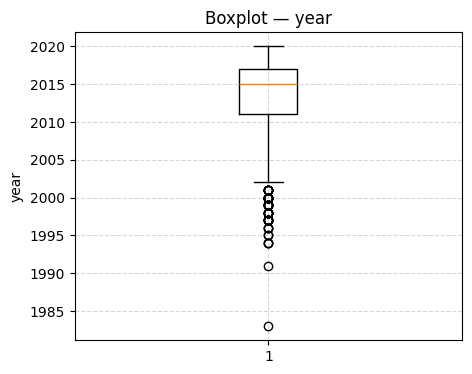

Cột: selling_price
   - Tổng số giá trị: 8128
   - Số ngoại lai: 600 (7.38%)
   - Độ lệch trung bình so với mean: 2329709.844
   Nhận xét: Nhiều ngoại lai — có thể ảnh hưởng mô hình.



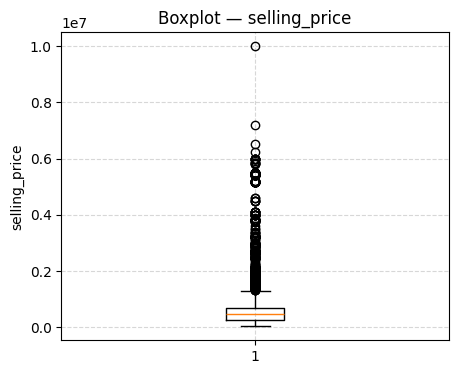

Cột: km_driven
   - Tổng số giá trị: 8128
   - Số ngoại lai: 170 (2.09%)
   - Độ lệch trung bình so với mean: 194786.7892
   Nhận xét: Số giá trị ngoại lai bình thường — chấp nhận được.



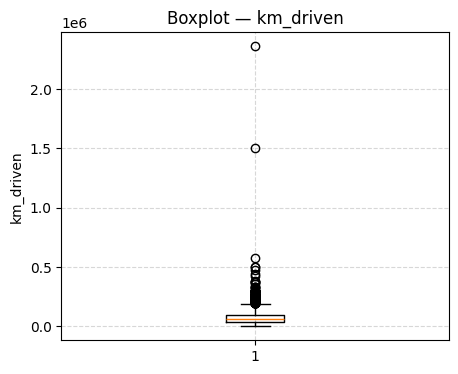

Cột: mileage
   - Tổng số giá trị: 8128
   - Số ngoại lai: 24 (0.3%)
   - Độ lệch trung bình so với mean: 18.094
   Nhận xét: Ít ngoại lai — không đáng lo ngại.



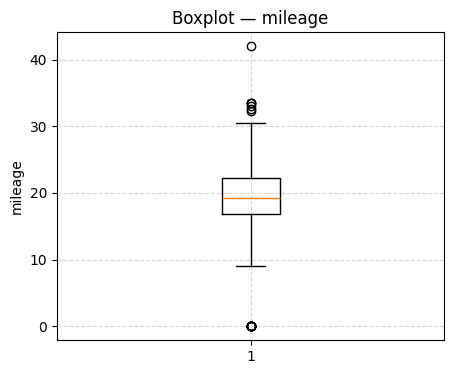

Cột: engine
   - Tổng số giá trị: 8128
   - Số ngoại lai: 1183 (14.55%)
   - Độ lệch trung bình so với mean: 995.3031
   Nhận xét: Nhiều ngoại lai — có thể ảnh hưởng mô hình.



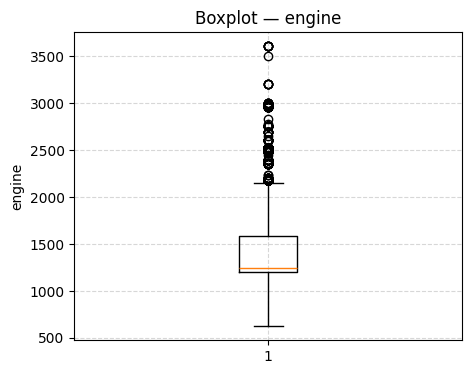

Cột: max_power
   - Tổng số giá trị: 8128
   - Số ngoại lai: 585 (7.2%)
   - Độ lệch trung bình so với mean: 94.1432
   Nhận xét: Nhiều ngoại lai — có thể ảnh hưởng mô hình.



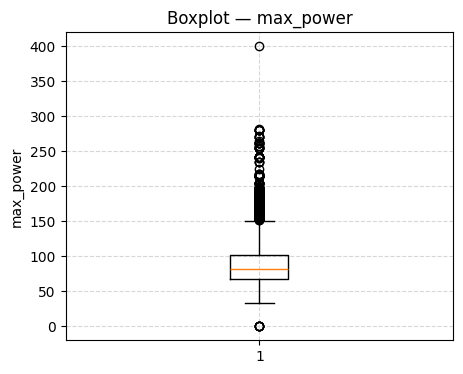

Cột: torque_value
   - Tổng số giá trị: 8128
   - Số ngoại lai: 497 (6.11%)
   - Độ lệch trung bình so với mean: 272.3849
   Nhận xét: Nhiều ngoại lai — có thể ảnh hưởng mô hình.



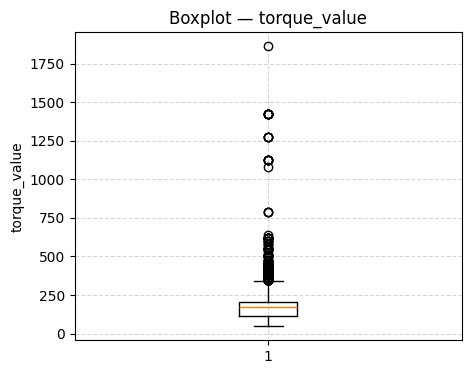

Cột: torque_rpm
   - Tổng số giá trị: 8128
   - Số ngoại lai: 0 (0.0%)
   Không phát hiện ngoại lai.



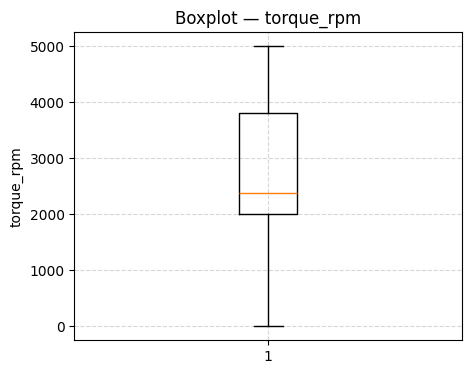

{'year': {'total': 8128,
  'outliers': 81,
  'percent': 1.0,
  'mean_difference': np.float64(15.3719)},
 'selling_price': {'total': 8128,
  'outliers': 600,
  'percent': 7.38,
  'mean_difference': np.float64(2329709.844)},
 'km_driven': {'total': 8128,
  'outliers': 170,
  'percent': 2.09,
  'mean_difference': np.float64(194786.7892)},
 'mileage': {'total': 8128,
  'outliers': 24,
  'percent': 0.3,
  'mean_difference': np.float64(18.094)},
 'engine': {'total': 8128,
  'outliers': 1183,
  'percent': 14.55,
  'mean_difference': np.float64(995.3031)},
 'max_power': {'total': 8128,
  'outliers': 585,
  'percent': 7.2,
  'mean_difference': np.float64(94.1432)},
 'torque_value': {'total': 8128,
  'outliers': 497,
  'percent': 6.11,
  'mean_difference': np.float64(272.3849)},
 'torque_rpm': {'total': 8128,
  'outliers': 0,
  'percent': 0.0,
  'mean_difference': 0}}

In [88]:
# Tìm và đánh giá ngoại lai
dp.detect_outliers(method="iqr")

In [89]:
# Chuẩn hóa dữ liệu số
dp.scale_numeric(method="standard")
# Chuyển dữ liệu phân loại thành số
dp.encode_categories(method="label")

Sử dụng StandardScaler (Chuẩn hóa Z-score)
Đã chuẩn hóa 16 cột số: ['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'torque_value', 'torque_rpm', 'year_std', 'selling_price_std', 'km_driven_std', 'mileage_std', 'engine_std', 'max_power_std', 'torque_value_std', 'torque_rpm_std']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                8128 non-null   object 
 1   year                8128 non-null   int64  
 2   selling_price       8128 non-null   int64  
 3   km_driven           8128 non-null   int64  
 4   fuel                8128 non-null   object 
 5   seller_type         8128 non-null   object 
 6   transmission        8128 non-null   object 
 7   owner               8128 non-null   object 
 8   mileage             8128 non-null   float64
 9   engine              8128 non-null   float64
 

None

In [92]:
# Xuất file đã xử lý
dp.save("data_processed.csv", "data_encoders.csv")

✔ Đã lưu dataframe tại: data_processed.csv
Đã lưu encoders tại: data_encoders.csv
